In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import yfinance as yf
from scipy.signal import argrelextrema
# from collections import deque
# from matplotlib.lines import Line2D
import pandas_ta as ta
import ccxt
from datetime import datetime, timedelta
# import plotly.graph_objects as go
# import inspect 
import os


pd.set_option('display.max_rows', None)



In [2]:

exchange = ccxt.binance()
exchange.load_markets()

symbols = exchange.symbols


# ticker = 'BTC-USDT'
# timeframe ='4h'
# use bars[:-1] to avoid false signal espeacially in current candle
# because ccxt gives the ongoing candle before they close
# do bars[:-3] to get less trades; but better quality
def ccxt_data(symbol='ETH/USDT', timeframe ='4h', limit=111):
    global data
    # global fullname

    m_symbol = symbol.replace("/","_")
    outname = m_symbol+'_'+timeframe+'_'+f'{limit}'+'.csv'
    outdir=os.getcwd()+f'/data/{timeframe}'
    fullname = os.path.join(outdir, outname)    

    if not os.path.exists(outdir):
        os.mkdir(outdir)

    if not (os.path.exists(fullname)):

        bars = exchange.fetch_ohlcv(symbol, timeframe, limit)
        # must use bars[:-1] because arrgrelextrema will see the last candle wich have not closed yet
        data = pd.DataFrame(bars[:-1], columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
        data['Time'] = pd.to_datetime(data['Time'], unit='ms')
        data.set_index('Time', inplace=True)

        data.to_csv(fullname) 
        print('fetching new data', symbol)
    
    else:
        tem_data = pd.read_csv(fullname, index_col='Time')
        # last_candle_time=tem_data['Time'].max()
        last_candle_time_plus=pd.to_datetime(tem_data.index[-1]) + pd.Timedelta(12, unit="h")
        if (last_candle_time_plus) >= pd.to_datetime(datetime.now()) :
            data = tem_data
        else:
            bars = exchange.fetch_ohlcv(symbol, timeframe, limit)
            data = pd.DataFrame(bars[:-1], columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
            data['Time'] = pd.to_datetime(data['Time'], unit='ms')
            data.set_index('Time', inplace=True)

            data.to_csv(fullname)
            print('updating data ',symbol)
            

    return data

In [3]:
# # ticker = 'BTC-USDT'
# # timeframe ='4h'
# # use bars[-1] to avoid false signal espeacially in current candle
# # because ccxt gives the ongoing candle before they close
# # do bars[-3] to get less trades; but better quality
# def ccxt_data(symbol='BTC/USDT', timeframe ='1d', limit=100):
#     global data

#     # if csv file not exist 
#     # os.path.exists(path_to_file)
#     # os.path.exists(os.getcwd()+f'/data/{timeframe}/{outname}')

#     bars = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
#     data = pd.DataFrame(bars[:-3], columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
#     data['Time'] = pd.to_datetime(data['Time'], unit='ms')
#     data.set_index('Time', inplace=True)
    
#     m_symbol = symbol.replace("/","_")
#     outname = m_symbol+'_'+timeframe+'_'+f'{limit}'
    
#     outdir=os.getcwd()+f'/data/{timeframe}'

#     # outdir = f'./dir/data/{timeframe}'
#     if not os.path.exists(outdir):
#         os.mkdir(outdir)

#     fullname = os.path.join(outdir, outname)    

#     data.to_csv(fullname) 

#     # else
#     # data = read csv 
#     #   

#     return data



In [4]:
# def savetocsv(symbol, timeframe, limit):
#     # outname = 'name.csv'
#     m_symbol = symbol.replace("/","_")
#     outname = m_symbol+'_'+timeframe+'_'+f'{limit}'
    
#     outdir=os.getcwd()+f'/data/{timeframe}'

#     # outdir = f'./dir/data/{timeframe}'
#     if not os.path.exists(outdir):
#         os.mkdir(outdir)

#     fullname = os.path.join(outdir, outname)    

#     data.to_csv(fullname)

In [5]:
# data=ccxt_data()

def calc():

    global peaks_df
    global troughs_df
    
    # data=ccxt_data()
    # calc indicator
    data['ta_rsi'] = ta.rsi(data['Close'], length = 14)

    # if (data['ta_rsi'].size > 14) and (data['Close'].size > 14) :
    # calc peaks and troughs of close price and the indicator(s)
    coin_peak = argrelextrema(data['Close'].values, np.greater, order=5)[0]
    # print(coin_peak)
    coin_peaks_df = data.iloc[coin_peak]['Close']
    # print(coin_peaks_df)

    ta_peak = argrelextrema(data['ta_rsi'].values, np.greater, order=5)[0]
    ta_peaks_df = data.iloc[ta_peak]['ta_rsi']
    # print(ta_peaks_df)

    coin_trough = argrelextrema(data['Close'].values, np.less, order=5)[0]
    coin_trough_df = data.iloc[coin_trough]['Close']

    ta_trough = argrelextrema(data['ta_rsi'].values, np.less, order=5)[0]
    ta_trough_df = data.iloc[ta_trough]['ta_rsi']

    peaks = [coin_peaks_df, ta_peaks_df]
    peaks_df = pd.concat(peaks, axis=1)
    peaks_df = peaks_df[(peaks_df.Close.notna()) & (peaks_df.ta_rsi.notna())]

    troughs = [coin_trough_df, ta_trough_df]
    troughs_df = pd.concat(troughs, axis=1)
    troughs_df = troughs_df[(troughs_df.Close.notna()) & (troughs_df.ta_rsi.notna())]

    return peaks_df, troughs_df

    
    
 

    # print(peaks)

    


# def trough_diff(n=1):

#     diff = troughs_df.diff(n)
#     sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
#     return sig

# def peak_diff(n=1):

#     diff = peaks_df.diff(n)
#     sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
#     return sig
# calc()

In [6]:
# calc()
# peaks_df.Close.iloc[-1]
# i think the problem is in the index
# it should be regular 1 2 3 4 5 6 ....


In [7]:

# peaks_df, troughs_df = calc()

def signal_dates(n=9):
    # peaks_df, troughs_df = calc()
    if (peaks_df.size > 0) and (troughs_df.size > 0):

        dates_of_peaks = []
        for i in range(n):
            if i == 0:
                diff = peaks_df.diff(1)
                sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
                dates_of_peaks.append(sig.index.values)
                continue
            diff = peaks_df.diff(i)
            sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
            dates_of_peaks.append(sig.index.values)

        dates_of_troughs = []
        for i in range(n):
            if i == 0:
                diff = troughs_df.diff(1)
                sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
                dates_of_troughs.append(sig.index.values)
                continue
            diff = troughs_df.diff(i)
            sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
            dates_of_troughs.append(sig.index.values)

        global sell
        sell = []
        for list in dates_of_peaks:
            for i in list:
                if str(i) not in sell:
                    # i = i + np.timedelta64(4, 'h') # adj sell date
                    # sell.append(pd.to_datetime(i))
                    sell.append(str(i))

        global buy
        buy = []
        for list in dates_of_troughs:
            for i in list:
                if str(i) not in buy:
                    # i = i + np.timedelta64(4, 'h')
                    # buy.append(pd.to_datetime(i))
                    buy.append(str(i))
                    

        sell.sort()
        buy.sort()
        # print(dates_of_peaks)
        # problem : buy ans sell should be list of datetime***********************

        # sell=pd.to_datetime(sell)
        # buy=pd.to_datetime(buy)


        return sell, buy

# signal_dates()


In [8]:
# def bsm_allah(ticker='BTC/USDT',timeframe='4h',limit=100):
    
#     ccxt_data(ticker,timeframe,limit)
#     calc()
#     signal_dates()
#     # sell, buy = signal_dates()

#     # ticker = str(inspect.signature(bsm_allah).parameters['ticker'])
#     # timeframe = str(inspect.signature(bsm_allah).parameters['timeframe'])

#     print(f'last buy signal was {buy[-1]}')
#     # global buy_list_dates 
#     # buy_list_dates = []
#     # buy_list_dates.insert(len(buy_list_dates),buy[-1])

#     print(f'last sell signal was {sell[-1]}')
#     # global sell_list_dates 
#     # sell_list_dates = []
#     # sell_list_dates.insert(len(sell_list_dates),sell[-1])
     
# bsm_allah('EOS/BTC','1d',150)

In [9]:
def resulta():
    # rows =[] do not put it inside a loop 
    global table
    #  leads to many problems
    # l=list(filter(lambda x: buy[-1] if x==buy[-1] else peaks_df.Close.iloc[-1], data['Close']))
    # l=list(filter(lambda x: data['Close'] if x==buy[-1] else peaks_df.Close.iloc[-1], data['Close'].index.values))
    # l=list(filter(lambda x:  x==buy[-1] , data['Close'].index.values))

    if buy:
        # data viewer wont work if min default is not datetime


        # buy.append(buy[-1] + timedelta(hours=4))
        # sell_date.append(sell_date[-1] + timedelta(hours=4))

        # buy[-1]=buy[-1]+np.timedelta64(4, 'h')
        # adjsell=sell_date[-1]+np.timedelta64(4, 'h')

        # buy.insert(-1,buy[-1]+np.timedelta64(8, 'h'))

        sell_date = min((dt for dt in sell if dt > buy[-1]),default=buy[-1])
        # sell_date = sell_date + np.timedelta64(8, 'h')

        if sell_date > buy[-1]:
            trade_on = False
            # profit=((data.loc[sell_date[-1]]['Close']/data.loc[buy[-1]]['Close'])-1)*100
            
            # profit_since_buy = ((data.loc[str(sell_date)]['Close']/data.loc[str(buy[-1])]['Close'])-1)*100
            
            # watchout from the +2 you may not find the second candle
            # if (data.index.get_loc(sell_date)+2) 
            # real_sell = data.loc[data.index.get_loc(sell_date)+2]['Close']
            # real_buy = data.loc[data.index.get_loc(buy[-1])+2]['Close']
            

            # you can take number of candle than multply by time frame 
            # find implicit index of the buy and the sell than substract 
            # duration=data.index.get_loc(sell_date) - data.index.get_loc(buy[-1]) 
            # duration=pd.to_datetime(sell_date) - pd.to_datetime(buy[-1])
            selldate= sell_date
        

            if (peaks_df.size != 0):
                # try:
                # prev_peak=((peaks_df.Close.iloc[-1]/data.loc[buy[-1]]['Close'])-1)*100
                prev_peak=((peaks_df.Close.iloc[-1]/data.loc[buy[-1]]['Close'])-1)*100
                # prev_peak=((peaks_df.Close.iloc[-1]/data['Close'].apply(lambda x: buy[-1] if x==buy[-1] else peaks_df.Close.iloc[-1]))-1)*100
                # prev_peak=((peaks_df.Close.iloc[-1]/l[0])-1)*100

                # except:
                #     prev_peak=0
                #     print('prev_peak shit', symbol)
            
            else:
                prev_peak = 0
                print(f'peaks_df size is {peaks_df.size} =0 (no prev peak) {symbol}')
                print('probably token nexiste pa')

        else:
            trade_on = True
            # profit_since_buy = ((data.iloc[-1]['Close']/ data.loc[str(buy[-1])]['Close'])-1)*100
            # duration=0 # df column must be same type
            selldate = sell_date # its buy[-1] bcase of default arg in min

            if (peaks_df.size != 0):
                # try:
                prev_peak=((peaks_df.Close.iloc[-1]/data.loc[buy[-1]]['Close'])-1)*100
                
                # prev_peak=((peaks_df.Close.iloc[-1]/data['Close'].apply(lambda x: buy[-1] if x==buy[-1] else peaks_df.Close.iloc[-1]))-1)*100
                # prev_peak=((peaks_df.Close.iloc[-1]/l[0])-1)*100
                
                # except:
                    # prev_peak=0
                    # print('prev_peak shit _nobuy', symbol)
            else:
                prev_peak = 0
                print(f'peaks_df size is {peaks_df.size} =0 (no prev peak) {symbol}')
                print('probably token nexiste pa or no peak found because order filter of argrelextrema is high 5 maybe so little peaks wont count')

        

        rows.append([symbol, buy[-1], selldate, trade_on,prev_peak])

        table = pd.DataFrame(rows, columns=["A", "Buy","Sell", "trade_on","prev_peak"])

        table['link'] = table['A'].apply(lambda x: f'<a href="https://www.tradingview.com/chart/UOC7kIDx/?symbol=BINANCE%3A{x.replace("/","")}">{x}</a>')

    else:
        # empty df
        rows.append([symbol, 0, 0, 0, 0,0,0])
        table = pd.DataFrame(rows, columns=["A", "Buy","Sell", "trade_on","profit_percent","prev_peak","duration"])
        print('no buy yet for ', symbol)

    # print('\n',l)        
    return table




In [10]:
# import pairs

t = 'BUSD'
pairs = []

unwanted = ["AION/BUSD","BCHA/BUSD","BLZ/BUSD","BOT/BUSD","BTS/BUSD","BTT/BUSD","BZRX/BUSD","COVER/BUSD","DCR/BUSD","ERD/BUSD","IRIS/BUSD","KMD/BUSD","LEND/BUSD","REP/BUSD","STRAT/BUSD","SWRV/BUSD","TRU/BUSD","VTHO/BUSD","WNXM/BUSD","UST","ETH/","BKRW","VAI","RUB","NGN","DAI","BIDR","BEAR", "BULL", "PAX", "TUSD", "UMA", "USDC", "USDP", "BUSD/", "EUR", "USDT", "GBP", "TRY", "AUD","BRL", "BVND"]

for s in symbols:
    if (t in s):
        pairs.append(s)

pairs=[n for n in pairs if all(m not in n for m in unwanted)]


_pairs = ["GLMR/BUSD", "AION/BUSD"]

In [11]:
from IPython.core.display import display, HTML


# always put the list out of the loop or everthing will be wiped out each turn
timeframe = '4h'
limit = 111
rows = []
for symbol in pairs:
   
    ccxt_data(symbol,timeframe,limit)
    # savetocsv(symbol,timeframe,limit)
    if data.size > 14:
        calc()
        signal_dates()
        resulta()
    else:
        print(symbol)
    # remeber if you get "IndexError: list index out of range" while using buy[-1]
    # that means buy, sell_date list is empty so no signals yet

    # sell_date=min(sell_date, key=lambda d: (d - buy[-1])>0)
    # buy=list(buy)
        # sell=list(sell)
   
    

LOKA/BUSD


In [13]:
display(HTML(resulta().to_html(escape=False)))


,A,Buy,Sell,trade_on,prev_peak,link
0,1INCH/BUSD,2022-01-19 04:00:00,2022-01-19 04:00:00,True,17.332691,1INCH/BUSD
1,AAVE/BUSD,2022-01-19 20:00:00,2022-01-19 20:00:00,True,11.031859,AAVE/BUSD
2,ACH/BUSD,2022-01-20 04:00:00,2022-01-20 04:00:00,True,22.712871,ACH/BUSD
3,ACM/BUSD,2022-01-19 04:00:00,2022-01-19 04:00:00,True,9.063830,ACM/BUSD
4,ADA/BUSD,2022-01-19 20:00:00,2022-01-19 20:00:00,True,-1.795064,ADA/BUSD
5,ADX/BUSD,2022-01-14 08:00:00,2022-01-15 12:00:00,False,5.331680,ADX/BUSD
6,AERGO/BUSD,2022-01-14 08:00:00,2022-01-15 00:00:00,False,4.923077,AERGO/BUSD
7,AGLD/BUSD,2022-01-14 08:00:00,2022-01-14 12:00:00,False,7.307979,AGLD/BUSD
8,ALCX/BUSD,2022-01-14 08:00:00,2022-01-14 16:00:00,False,7.710280,ALCX/BUSD
9,ALGO/BUSD,2022-01-19 04:00:00,2022-01-19 04:00:00,True,12.655585,ALGO/BUSD


In [14]:
buy

['2022-01-08 16:00:00', '2022-01-10 12:00:00', '2022-01-14 08:00:00']

In [15]:
# # test strategy

# # f = open('C:\\Users\\Grant\\virenv\\ttm\\txts\\usdt.txt', 'r')
# # content = f.read()

# from IPython.core.display import display, HTML


# # always put the list out of the loop or everthing will be wiped out each turn
# rows = []

# for symbol in pairs:

#     try:
#         ccxt_data(symbol,'4h',111)
#         calc()
#         signal_dates()
#         # remeber if you get "IndexError: list index out of range" while using buy[-1]
#         # that means buy, sell list is empty so no signals yet
        
#         # sellafterbuy=min(sell, key=lambda d: (d - buy[-1])>0)

#         sellafterbuy = min(dt for dt in sell if dt > buy[-1])


#     #   if sellafterbuy:
#         if sell[-1] > buy[-1]:
#             trade_on = False
#             # percentage=((data.loc[sell[-1]]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#             percentage=((data.loc[sellafterbuy]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#             duration=sellafterbuy - buy[-1]
#             last_peak=((peaks_df.Close[-2]/data.loc[buy[-1]]['Close'])-1)*100
#             selldate= sellafterbuy
#         else:
#             trade_on = True
#             percentage= 0
#             duration=buy[-1]
#             last_peak=((peaks_df.Close[-1]/data.loc[buy[-1]]['Close'])-1)*100
#             selldate = 0

#         # if sellafterbuy > buy[-1]:
#         #     trade_on = False
#         #     # percentage=((data.loc[sell[-1]]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#         #     percentage=((data.loc[sellafterbuy]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#         #     duration=sellafterbuy - buy[-1]
#         #     last_peak=((peaks_df.Close[-2]/data.loc[buy[-1]]['Close'])-1)*100
#         # else:
#         #     trade_on = True
#         #     percentage= 0
#         #     duration=buy[-1]
#         #     last_peak=((peaks_df.Close[-1]/data.loc[buy[-1]]['Close'])-1)*100


#         rows.append([symbol, buy[-1], selldate, trade_on, percentage,last_peak,duration])
        
#         df = pd.DataFrame(rows, columns=["A", "Buy","Sell", "trade_on","profit_percent","last_peak","duration"])

#         df['link'] = df['A'].apply(lambda x: f'<a href="https://www.tradingview.com/chart/UOC7kIDx/?symbol=BINANCE%3A{x.replace("/","")}">{x}</a>')
        

#     except:
#         print(f"{symbol}")
        

# # TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'
# # ta_peak = argrelextrema(data['ta_rsi'].values, np.greater, order=5)[0]
# # the error happend at one/eth so i looked in trading view
# # it had no rsi so thats the problem





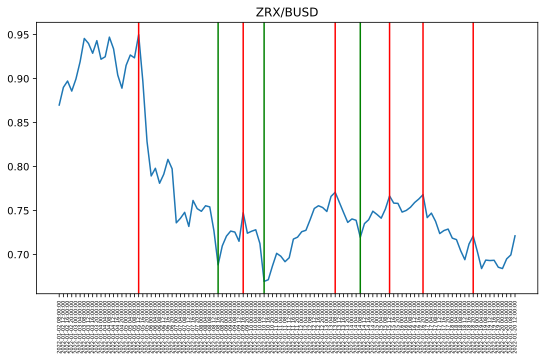

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(9, 5))
plt.plot(data['Close'], zorder=0)

# sell, buy = signal_dates()


for xc in buy:
    plt.axvline(x=xc,color='g')

for xc in sell:
    plt.axvline(x=xc,color='r')


# draw the last call only
# b = buy[-1]
# plt.axvline(x=b,color='g')

# s = sell[-1]
# plt.axvline(x=s,color='r')
plt.title(symbol)
# plt.legend()
plt.xticks(rotation='vertical', fontsize = 5)

# plt.gcf().autofmt_xdate()


plt.show()



In [17]:
s=ta.ha(data['Open'],data['High'],data['Low'],data['Close'])


In [18]:
# l = [0,2,3,5,8,7,4,5,2,1,5]

# dff = pd.DataFrame(l[:-2])

# dff